In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
#這兩行讓 matplotlib 的圖可以顯示中文，同時正常顯示負號
matplotlib.rc('font', family='Microsoft JhengHei')
plt.rcParams['axes.unicode_minus'] = False
import datetime
from copy import deepcopy
import os
import joblib
import json
from tqdm import tqdm
import optuna

# 設置Optuna日誌級別為 WARNING，僅顯示警告及以上級別的信息
optuna.logging.set_verbosity(optuna.logging.WARNING)

pd.set_option('future.no_silent_downcasting', True)

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.svm import SVR, NuSVR

from scipy.optimize import minimize

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [4]:
from Pytorch_models.metrics import Array_Metrics
from Pytorch_models import models as pytorch_models
from Pytorch_models import api
MAE = Array_Metrics.mae
R2_score = Array_Metrics.r2

In [5]:
optuna_done = {
    '日照率': True,
    '最高氣溫': True,
    '最低氣溫': True,
    '氣溫': True,
    '風速': True,
    '夜尖峰': False,
}

weights_determined = {
    '日照率': True,
    '最高氣溫': True,
    '最低氣溫': True,
    '氣溫': True,
    '風速': True,
    '夜尖峰': False,
}

# 整理資料

In [6]:
data_path = './historical/data/weather/finalized/'
forecast_path = data_path + 'weather_forecast.csv'
observation_path = data_path + 'big_table.csv'
train_model_path = './trained_model_parameters/model_meta_2024-08-28/'

In [7]:
town_and_station = {
    '臺北市中正區': '臺北',
    '高雄市楠梓區': '高雄',
    '嘉義市西區': '嘉義',
    '澎湖縣望安鄉': '東吉島',
    '臺中市龍井區': '臺中電廠',
    '雲林縣臺西鄉': '臺西'
}

In [8]:
forecast_df = pd.read_csv(forecast_path)
observation_df = pd.read_csv(observation_path)
forecast_df['日期'] = pd.to_datetime(forecast_df['日期'])
observation_df['日期'] = pd.to_datetime(observation_df['日期'])
power_df = pd.read_csv('./historical/data/power/power_generation_data.csv')
power_df['日期'] = pd.to_datetime(power_df['日期'])

In [9]:
station_names = ['臺北', '高雄', '嘉義', '東吉島', '臺中電廠']
col_map = {col: col.split('(')[0] for col in observation_df.columns}

observation_df = deepcopy(observation_df)
observation_df.rename(columns=col_map, inplace=True)

for i in tqdm(observation_df.index):
    for col in observation_df.columns:
        if not col in ['站名', '日期']:
            try:
                observation_df.loc[i, col] = np.float32(observation_df.loc[i, col])
            except:
                if observation_df.loc[i, col] == 'T':
                    observation_df.loc[i, col] = 0
                else:
                    observation_df.loc[i, col] = np.nan

100%|█████████████████████████████████████████████████████████████████████████████| 3642/3642 [00:06<00:00, 547.18it/s]


In [10]:
prefixes = [['風速', '風向'], ['最大瞬間風', '最大瞬間風風向']]

wind_speed = list(observation_df[prefixes[0][0]])
wind_direction = list(observation_df[prefixes[0][1]] / 180 * np.pi)
NS_wind = np.abs(wind_speed * np.cos(wind_direction))
EW_wind = np.abs(wind_speed * np.sin(wind_direction))
observation_df['東西風'] = EW_wind
observation_df['南北風'] = NS_wind

wind_speed = list(observation_df[prefixes[1][0]])
wind_direction = list(observation_df[prefixes[1][1]] / 180 * np.pi)
NS_wind = np.abs(wind_speed * np.cos(wind_direction))
EW_wind = np.abs(wind_speed * np.sin(wind_direction))
observation_df['東西陣風'] = EW_wind
observation_df['南北陣風'] = NS_wind

observation_df.drop(['風向', '最大瞬間風風向'], axis=1, inplace=True)

In [11]:
observation_df

,站名,日期,氣溫,最高氣溫,最低氣溫,相對溼度,風速,最大瞬間風,降水量,降水時數,日照時數,日照率,全天空日射量,總雲量,東西風,南北風,東西陣風,南北陣風
0,臺北,2023-01-01,19.299999,22.000000,16.799999,83.0,3.2,12.5,1.5,2.6,0.5,4.7,8.98,9.0,3.200000,1.959435e-16,12.310097,2.170602e+00
1,臺北,2023-01-02,18.500000,20.400000,16.600000,89.0,2.6,11.1,2.0,6.6,0.0,0.0,4.00,9.8,2.600000,1.592041e-16,11.100000,6.796790e-16
2,臺北,2023-01-03,16.100000,17.700001,14.400000,89.0,3.0,12.6,0.0,2.3,0.0,0.0,7.10,10.0,3.000000,1.836970e-16,10.911920,6.300000e+00
3,臺北,2023-01-04,16.299999,17.900000,14.500000,90.0,3.1,11.0,0.0,5.9,0.2,1.9,6.24,9.0,3.100000,1.898202e-16,9.526279,5.500000e+00
4,臺北,2023-01-05,19.299999,22.200001,17.200001,90.0,2.0,9.3,1.0,2.8,1.3,12.3,9.25,8.4,2.000000,1.224647e-16,9.300000,5.694608e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,臺中電廠,2024-08-25,29.500000,32.599998,26.200001,73.0,1.5,7.7,0.0,0.0,NaN,NaN,NaN,NaN,1.299038,7.500000e-01,4.949464,5.898542e+00
3638,臺中電廠,2024-08-26,29.400000,32.299999,27.400000,78.0,1.7,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1.302276,1.092739e+00,NaN,NaN
3639,臺中電廠,2024-08-27,30.299999,33.500000,27.299999,74.0,1.5,6.4,0.0,0.0,NaN,NaN,NaN,NaN,0.513030,1.409539e+00,5.542563,3.200000e+00
3640,臺中電廠,2024-08-28,30.900000,34.299999,27.400000,75.0,1.5,6.8,0.0,0.0,NaN,NaN,NaN,NaN,0.260472,1.477212e+00,2.325737,6.389910e+00


In [12]:
np.sum(observation_df[['氣溫', '最高氣溫', '最低氣溫', '風速', '日照率']].isna())

C:\Users\skyja\anaconda3\envs\taipower\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


氣溫       184
最高氣溫      56
最低氣溫      56
風速        58
日照率     1214
dtype: int64

In [13]:
for hr in range(0, 24, 3):
    
    wind_speed = list(forecast_df[f'{prefixes[0][0]}_{hr}'])
    wind_direction = list(forecast_df[f'{prefixes[0][1]}_{hr}'] / 180 * np.pi)
    NS_wind = np.abs(wind_speed * np.cos(wind_direction))
    EW_wind = np.abs(wind_speed * np.sin(wind_direction))
    forecast_df[f'東西風_{hr}'] = EW_wind
    forecast_df[f'南北風_{hr}'] = NS_wind

    forecast_df.drop([f'風向_{hr}'], axis=1, inplace=True)

In [14]:
forecast_df

,鄉鎮,日期,晴_0,多雲_0,陰_0,短暫陣雨_0,短暫陣雨或雷雨_0,午後短暫雷陣雨_0,陣雨或雷雨_0,溫度_0,...,東西風_9,南北風_9,東西風_12,南北風_12,東西風_15,南北風_15,東西風_18,南北風_18,東西風_21,南北風_21
0,臺北市中正區,2024-07-11,1,0,0,0,0,0,0,28,...,3.000000,5.510911e-16,3.000000,5.510911e-16,2.000000e+00,3.673940e-16,2.000000,3.673940e-16,1.000000e+00,1.836970e-16
1,臺北市中正區,2024-07-12,1,0,0,0,0,0,0,28,...,0.573576,8.191520e-01,1.414214,1.414214e+00,4.898587e-16,2.000000e+00,0.707107,7.071068e-01,2.449294e-16,1.000000e+00
2,臺北市中正區,2024-07-13,1,0,0,0,0,0,0,29,...,0.573576,8.191520e-01,1.147153,1.638304e+00,1.000000e+00,6.123234e-17,0.707107,7.071068e-01,1.224647e-16,1.000000e+00
3,臺北市中正區,2024-07-14,1,0,0,0,0,0,0,29,...,3.000000,1.836970e-16,3.535534,3.535534e+00,2.828427e+00,2.828427e+00,1.414214,1.414214e+00,1.000000e+00,6.123234e-17
4,臺北市中正區,2024-07-15,0,0,1,0,0,0,0,29,...,0.707107,7.071068e-01,4.949747,4.949747e+00,4.949747e+00,4.949747e+00,2.828427,2.828427e+00,2.000000e+00,1.224647e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,雲林縣臺西鄉,2024-08-26,1,0,0,0,0,0,0,27,...,1.414214,1.414214e+00,3.000000,5.510911e-16,2.000000e+00,3.673940e-16,0.573576,8.191520e-01,5.735764e-01,8.191520e-01
302,雲林縣臺西鄉,2024-08-27,1,0,0,0,0,0,0,27,...,2.000000,3.673940e-16,3.000000,5.510911e-16,1.147153e+00,1.638304e+00,1.147153,1.638304e+00,1.224647e-16,1.000000e+00
303,雲林縣臺西鄉,2024-08-28,0,0,1,0,0,0,0,28,...,1.720729,2.457456e+00,1.720729,2.457456e+00,1.147153e+00,1.638304e+00,1.147153,1.638304e+00,1.224647e-16,1.000000e+00
304,雲林縣臺西鄉,2024-08-29,1,0,0,0,0,0,0,28,...,1.720729,2.457456e+00,1.720729,2.457456e+00,1.147153e+00,1.638304e+00,1.414214,1.414214e+00,1.224647e-16,1.000000e+00


In [15]:
power_df['夜尖峰'] = [1 if e<50 else 0 for e in power_df['太陽能發電']]
y_df = deepcopy(power_df[['日期', '夜尖峰']])
y_df

,日期,夜尖峰
0,2023-01-01,1
1,2023-01-02,1
2,2023-01-03,1
3,2023-01-04,1
4,2023-01-05,1
...,...,...
593,2024-08-25,1
594,2024-08-26,0
595,2024-08-27,0
596,2024-08-28,0


# 函數

## FCN model API

In [16]:
def FCN_model(input_f, output_f, feature_counts, dropout_factor=0, L2_factor=1e-15):
    model = pytorch_models.SimpleNN(input_f, output_f, feature_counts, dropout_factor)
    Model_API = api.Model_API(model, L2_factor=L2_factor)
    return Model_API

## Hyper Parameter Tuning

In [17]:
def get_XY_from_forecast_and_observation(forecast_df, observation_df, X_features, Y_feature):
    if Y_feature in ['降水時數', '日照時數', '日照率', '全天空日射量', '總雲量']:
        station_list = ['臺北', '高雄', '嘉義', '東吉島']
    else:
        station_list = ['臺北', '高雄', '嘉義', '東吉島', '臺中電廠', '臺西']

    X_cols = []
    for col in forecast_df.columns:
        if col.split('_')[0] in X_features:
            X_cols.append(col)

    Xs = []
    Ys = []
    town_and_date = []
    for i in range(len(forecast_df)):
        this_town = forecast_df['鄉鎮'].iloc[i]
        this_date = forecast_df['日期'].iloc[i]
        this_station = town_and_station[this_town]
    
        if this_station in station_list:
            this_obs = observation_df[observation_df['日期'] == this_date]
            this_row = this_obs[this_obs['站名']==this_station]
            if len(this_row) > 0:
                this_Y = this_row[Y_feature].iloc[0]
                if not pd.isna(this_Y):
                    Xs.append(np.array(forecast_df[X_cols].iloc[i]))
                    Ys.append(this_Y)
                    town_and_date.append((this_town, this_date))
    Xs = np.array(Xs)
    Ys = np.array(Ys)

    return Xs, Ys, X_cols, town_and_date

In [18]:
def five_fold_test(Xs, Ys, model=XGBRegressor(), deep_learning=False, fold_n=5, standard_scale=True, always_test_last_chunk=False):

    shuffle = not always_test_last_chunk
    kf = KFold(n_splits=fold_n, shuffle=shuffle)
    
    XY_folds = {}
    for i, (train_index, test_index) in enumerate(kf.split(Xs)):
        XY_folds[i] = (train_index, test_index)
    
    R2_test_list = []
    R2_train_list = []

    if always_test_last_chunk:
        iters = [fold_n-1]
    else:
        iters = range(fold_n)
    
    for i in iters:
        if deep_learning:
            input_f = model.model.params['input_f']
            output_f = model.model.params['output_f']
            feature_counts = model.model.params['feature_counts']
            dropout_factor = model.model.params['dropout_factor']
            L2_factor = model.L2_factor
            model = FCN_model(input_f=input_f, output_f=output_f, feature_counts=feature_counts,
                              dropout_factor=dropout_factor, L2_factor=L2_factor)
            
        X_train = Xs[XY_folds[i][0]]
        X_test = Xs[XY_folds[i][1]]
        Y_train = Ys[XY_folds[i][0]]
        Y_test = Ys[XY_folds[i][1]]

        if deep_learning:
            X_train_DL, X_val, Y_train_DL, Y_val = train_test_split(X_train, Y_train, test_size=0.20)
    
        if standard_scale:
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            if deep_learning:
                X_val = scaler.transform(X_val)
            
        if deep_learning:
            _ = model.fit(X_train_DL, Y_train_DL, X_val, Y_val)
        else:
            _ = model.fit(X_train, Y_train)
    
        Y_pred = model.predict(X_test)
        R2 = 1 - np.mean((Y_test - Y_pred)**2) / np.var(Y_test)
        R2_test_list.append(R2)

        mae_test = MAE(Y_test, Y_pred)

        Y_pred = model.predict(X_train)
        R2 = 1 - np.mean((Y_train - Y_pred)**2) / np.var(Y_train)
        R2_train_list.append(R2)

    # if deep_learning:
    #     print(mae_test)
    # if deep_learning:
    #     print(R2_train_list, R2_test_list)

    R2_test = np.mean(R2_test_list)
    R2_train = np.mean(R2_train_list)
    return R2_test, R2_train

In [19]:
def hyperparameter_tuning(trial, Xs, Ys, model_label='RandomForest', n_iters=50, always_test_last_chunk=False):
    deep_learning = False
    standard_scale = True
    if model_label in ['RandomForest', 'XGBoost', 'LightGBM']:
        cfg = {'max_depth': trial.suggest_int('max_depth', 2, 10),
               'n_estimators': trial.suggest_int('n_estimators', 10, 200)}
        max_depth = cfg['max_depth']
        n_estimators = cfg['n_estimators']
    
        if model_label == 'RandomForest':
            model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)
        elif model_label == 'XGBoost':
            model = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators)
        elif model_label == 'LightGBM':
            model = LGBMRegressor(force_col_wise=True, verbose=-1, max_depth=max_depth, n_estimators=n_estimators)
    elif model_label == 'SVR':
        cfg = {'C': trial.suggest_float('C', 1e-3, 2e2, log=True),
               'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])}
        C = cfg['C']
        kernel = cfg['kernel']
        model = SVR(C=C, kernel=kernel)
    elif model_label == 'NuSVR':
        cfg = {'C': trial.suggest_float('C', 1e-3, 2e2, log=True),
               'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
               'nu': trial.suggest_float('nu', 0.1, 0.9)}
        C = cfg['C']
        kernel = cfg['kernel']
        nu = cfg['nu']
        model = NuSVR(C=C, kernel=kernel, nu=nu)
    elif model_label == 'FCN':
        deep_learning = True
        standard_scale = False
        cfg = {'L2_factor': trial.suggest_float('L2_factor', 1e-3, 1, log=True),
               'dropout_factor': trial.suggest_float('dropout_factor', 0, 0.5)}
        L2_factor = cfg['L2_factor']
        dropout_factor = cfg['dropout_factor']
        input_f = Xs.shape[1] 
        output_f = 1 
        feature_counts = [16, 16, 16, 8]
        model = FCN_model(input_f=input_f, output_f=output_f, feature_counts=feature_counts,
                          dropout_factor=dropout_factor, L2_factor=L2_factor)
    elif model_label == 'LinearRegression':
        model = LinearRegression()
        
    R2_list = []
    # if model_label == 'FCN':
    #     iterator = tqdm(range(n_iters))
    # else:
    #     iterator = range(n_iters)
    iterator = range(n_iters)
    for i in iterator:
        R2, _ = five_fold_test(Xs, Ys, model, deep_learning=deep_learning, standard_scale=standard_scale, always_test_last_chunk=always_test_last_chunk)
        R2_list.append(R2)

    return np.mean(R2_list) - np.std(R2_list)
    

In [20]:
def optuna_operation(model_xcols, Y_feature, forecast_df, observation_df,
                     optuna_n_trials=30, n_iters=30, always_test_last_chunk=False):
    model_hyperparameters_dict = {}
    model_r2_dict = {}
    
    if always_test_last_chunk:
        n_iters = 1

    model_labels = list(model_xcols.keys())
    
    for model_label in model_labels:
        X_features = model_xcols[model_label]
        #Xs, Ys, X_cols = get_XY(weather_power_df, Y_feature=Y_feature)
        Xs, Ys, X_cols, town_and_date = get_XY_from_forecast_and_observation(forecast_df, observation_df, X_features, Y_feature)

        this_n_iters = n_iters
        this_optuna_n_trials = optuna_n_trials

        if model_label == 'FCN':
            this_n_iters = min(this_n_iters, 1)

        if model_label == 'LinearRegression':
            this_optuna_n_trials = 30
            this_n_iters = 10
            
        def target_func(trial, model_label=model_label, Xs=Xs, Ys=Ys, n_iters=this_n_iters, always_test_last_chunk=always_test_last_chunk):
            return hyperparameter_tuning(trial, model_label=model_label, Xs=Xs, Ys=Ys, n_iters=n_iters, always_test_last_chunk=always_test_last_chunk)
        
        sampler = optuna.samplers.TPESampler()
        study = optuna.create_study(sampler=sampler, direction='maximize')
        with tqdm(total=this_optuna_n_trials) as pbar:
            for _ in range(this_optuna_n_trials):
                study.optimize(target_func, n_trials=1, catch=(Exception,))
                pbar.update(1)
        
        # if model_label == 'FCN':
        #     study.optimize(target_func, n_trials=this_optuna_n_trials)
        # else:
        #     with tqdm(total=this_optuna_n_trials) as pbar:
        #         for _ in range(this_optuna_n_trials):
        #             study.optimize(target_func, n_trials=1, catch=(Exception,))
        #             pbar.update(1)
    
        print(model_label)
        for key, v in study.best_params.items():
            print(f"Best {key} = {v}")
        print(f"Best R2 = {study.best_value}")
    
        model_hyperparameters_dict[model_label] = study.best_params
        model_r2_dict[model_label] = study.best_value
        
    for model_label in model_labels:
        print('##### ' + model_label)
        for key, v in model_hyperparameters_dict[model_label].items():
            print(f"Best {key} = {v}  ")
        print(f"Best R2 = {model_r2_dict[model_label]}  ")

    return model_hyperparameters_dict

## Ensemble

In [21]:
def cross_correlation_matrix(residuals):
    N = len(residuals)
    matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(i, N):
            #print([i, j])
            matrix[i][j] = np.mean(np.array(residuals[i]) * np.array(residuals[j]))

    for i in range(1, N):
        for j in range(i):
            #print([i, j])
            matrix[i][j] = matrix[j][i]

    return matrix

In [22]:
def sovle_optimal_weights(matrix):
    N = matrix.shape[0]
    def objective(weights):
        return weights.T @ matrix @ weights

    initial_weights = np.array([1/N] * N)
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * N
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    optimal_weights = result.x
    return optimal_weights

In [33]:
def assign_model(model_label, Xs, model_hyperparameters_dict, mode='regressor'):
    if mode == 'regressor':
        if model_label == 'LinearRegression':
            model = LinearRegression()
        elif model_label == 'RandomForest':
            model = RandomForestRegressor(**model_hyperparameters_dict[model_label])
        elif model_label == 'XGBoost':
            model = XGBRegressor(**model_hyperparameters_dict[model_label])
        elif model_label == 'LightGBM':
            model = LGBMRegressor(force_col_wise=True, verbose=-1, **model_hyperparameters_dict[model_label])
        elif model_label == 'SVR':
            model = SVR(**model_hyperparameters_dict[model_label])
        elif model_label == 'NuSVR':
            model = NuSVR(**model_hyperparameters_dict[model_label])
        elif model_label == 'FCN':
            input_f = Xs.shape[1]
            output_f = 1
            feature_counts = [16, 16, 16, 8]
            deep_learning = True
            model = FCN_model(input_f=input_f, output_f=output_f, feature_counts=feature_counts,
                      **model_hyperparameters_dict[model_label])
    return model
    

In [23]:
def find_avg_score_with_given_model_list(model_hyperparameters_dict, model_xcols,
                                         data_df, Y_feature, mode='regressor',
                                         n_iters=200, weights=None):

    if mode == 'regressor':
        metric_name = 'MAE'
    elif mode == 'classifier':
        metric_name = 'F1'
    
    if type(data_df) in [list, tuple]:
        if len(data_df) == 2:
            forecast_df, observation_df = data_df
            target = 'obs'
        else:
            raise Exception('Input data_df should be a DataFrame or a list contain 2 DataFrames.')
    else:
        target = 'pwd'
    
    def get_prediction(model_label, Y_train, train_ind, test_ind,
                       model_hyperparameters_dict=model_hyperparameters_dict,
                       model_xcols=model_xcols,
                       forecast_df=forecast_df,
                       observation_df=observation_df, 
                       Y_feature=Y_feature,
                       target=target):
        
        X_features = model_xcols[model_label]
        if target == 'pwd':
            Xs, _, _ = get_XY(data_df, Y_feature=Y_feature, X_features=X_features)
        elif target == 'obs':
            Xs, _, _, _ = get_XY_from_forecast_and_observation(forecast_df, observation_df, X_features, Y_feature)
        model = assign_model(model_label, Xs, model_hyperparameters_dict=model_hyperparameters_dict, mode=mode)

        deep_learning = False
        if model_label == 'FCN':
            deep_learning = True
    
        X_train = Xs[train_ind]
        X_test = Xs[test_ind]
        
        if deep_learning:
            X_train_dl, X_val, Y_train_dl, Y_val = train_test_split(X_train, Y_train, test_size=0.20)
            _ = model.fit(X_train_dl, Y_train_dl, X_val, Y_val)
        else:
            scaler = StandardScaler()
            X_scaler = scaler.fit(X_train)
            X_train = X_scaler.transform(X_train)
            X_test = X_scaler.transform(X_test)
            _ = model.fit(X_train, Y_train)
        YP = model.predict(X_test)
        return YP        
    
    if weights is None:
        ensemble_models = list(model_hyperparameters_dict.keys())
    else:
        ensemble_models = list(weights.keys())
        
    Y_pred_iters = []
    Y_test_iters = []
    metric = []

    X_features=model_xcols[ensemble_models[0]]
    if target == 'pwd':
        Xs, Ys, _ = get_XY(data_df, Y_feature=Y_feature, X_features=X_features)
    elif target == 'obs':
        Xs, Ys, _, _ = get_XY_from_forecast_and_observation(forecast_df, observation_df, X_features, Y_feature)

    matrix = np.zeros((len(ensemble_models), len(ensemble_models)))
    for i in tqdm(range(n_iters)):
        train_ind, test_ind, _, _ = train_test_split(np.arange(Xs.shape[0]), np.arange(Xs.shape[0]), test_size=0.20)
        
        Y_train = Ys[train_ind]
        Y_test = Ys[test_ind]
        
        Y_preds = []
        this_metric = []
        for model_label in ensemble_models:
            YP = get_prediction(model_label, Y_train, train_ind, test_ind)
            if mode == 'regressor':
                this_metric.append(MAE(Y_test, YP))
            elif mode == 'classifier':
                YP[np.where(YP<0.5)] = 0
                YP[np.where(YP>=0.5)] = 1
                this_metric.append(f1_score(Y_test, YP))
            Y_preds.append(YP)
            
        residuals = Y_preds - np.array([Y_test] * len(Y_preds)).reshape(len(Y_preds),-1)
        if weights is None:
            matrix += cross_correlation_matrix(residuals)

        uniform_ensemble_YP = np.mean(Y_preds, axis=0)
        if mode == 'regressor':
            this_metric.append(MAE(Y_test, uniform_ensemble_YP))
        elif mode == 'classifier':
            uniform_ensemble_YP[np.where(uniform_ensemble_YP<0.5)] = 0
            uniform_ensemble_YP[np.where(uniform_ensemble_YP>=0.5)] = 1
            this_metric.append(f1_score(Y_test, uniform_ensemble_YP))

        metric.append(this_metric)
        Y_pred_iters.append(Y_preds)
        Y_test_iters.append(Y_test)

    if weights is None:
        matrix = matrix / n_iters
        optimal_weights = sovle_optimal_weights(matrix)
    else:
        optimal_weights = weights

    weighted_metric = []
    for i in range(n_iters):
        weighted_YP = np.sum(Y_pred_iters[i] * np.concatenate([optimal_weights.reshape(-1,1),] * Y_test_iters[0].shape[0], axis = 1), axis=0)
        if mode == 'regressor':
            weighted_metric.append(MAE(Y_test_iters[i], weighted_YP))
        elif mode == 'classifier':
            weighted_YP[np.where(weighted_YP<0.5)] = 0
            weighted_YP[np.where(weighted_YP>=0.5)] = 1
            weighted_metric.append(f1_score(Y_test_iters[i], weighted_YP))
    weighted_metric = np.array(weighted_metric).reshape(-1, 1)
    array_metric = np.array(metric)
    array_metric = np.concatenate([metric, weighted_metric], axis=1)
    
    metric_dict = {
        'Model': ensemble_models + ['Ensemble', 'Weighted_Ensemble'],
        f'Avg {metric_name}': list(np.mean(array_metric, axis=0)), 
        f'Std {metric_name}': list(np.std(array_metric, axis=0)),
        '90th percentile': list(np.sort(array_metric, axis=0)[int(array_metric.shape[0] * 0.9) - 1]),
        '10th percentile': list(np.sort(array_metric, axis=0)[int(array_metric.shape[0] * 0.1) - 1])
        }
    
    df = pd.DataFrame(metric_dict)
    if mode == 'regressor':
        df = df.sort_values('90th percentile').reset_index(drop=True)
    elif mode == 'classifier':
        df = df.sort_values('10th percentile').reset_index(drop=True)

    if weights is not None:
        return df
        
    optimal_weights_dict = {}
    for i, w in enumerate(optimal_weights):
        optimal_weights_dict[ensemble_models[i]] = w
        
    return df, optimal_weights_dict

In [24]:
def save_model_metadata(Y_feature, file_path, model_xcols, model_hyperparameters_dict, optimal_weights):
    model_labels = list(model_hyperparameters_dict)
    output_dict = {
        'X_feature_dict':{},
        'hyperparameters_dict':{},
        'weights':{}
    }
    for model_label in model_labels:
        if optimal_weights[model_label] > 0.0005:
            output_dict['X_feature_dict'][model_label] = model_xcols[model_label]
            output_dict['hyperparameters_dict'][model_label] = model_hyperparameters_dict[model_label]
            output_dict['weights'][model_label] = optimal_weights[model_label]

    with open(file_path, 'w') as f:
        json.dump(output_dict, f)

# 日照率

## Hyper_Parameter Tuning

In [26]:
Y_feature = '日照率'
if os.path.exists(f'{train_model_path}{Y_feature}/meta.json'):
    with open(f'{train_model_path}{Y_feature}/meta.json', 'r') as f:
        meta = json.load(f)
else:
    optuna_done[Y_feature] = False
    weights_determined[Y_feature] = False

In [28]:
Y_feature = '日照率'
if optuna_done[Y_feature]:
    model_xcols = meta['X_feature_dict']
    model_hyperparameters_dict = meta['hyperparameters_dict']
else:
    model_xcols = {
        'RandomForest': ['晴', '多雲', '陰', '短暫陣雨', '短暫陣雨或雷雨', '午後短暫雷陣雨', '陣雨或雷雨', '相對溼度'],
        'XGBoost': ['晴', '多雲', '陰', '短暫陣雨', '短暫陣雨或雷雨', '午後短暫雷陣雨', '陣雨或雷雨', '相對溼度'],
        'LightGBM': ['晴', '多雲', '陰', '短暫陣雨', '短暫陣雨或雷雨', '午後短暫雷陣雨', '陣雨或雷雨', '相對溼度'],
        'SVR': ['晴', '多雲', '陰', '短暫陣雨', '短暫陣雨或雷雨', '午後短暫雷陣雨', '陣雨或雷雨', '相對溼度'],
        'NuSVR': ['晴', '多雲', '陰', '短暫陣雨', '短暫陣雨或雷雨', '午後短暫雷陣雨', '陣雨或雷雨', '相對溼度'],
        'FCN': ['晴', '多雲', '陰', '短暫陣雨', '短暫陣雨或雷雨', '午後短暫雷陣雨', '陣雨或雷雨', '相對溼度'],
    }
    model_hyperparameters_dict = optuna_operation(model_xcols, Y_feature, forecast_df, observation_df)

##### RandomForest
Best max_depth = 6  
Best n_estimators = 157  
Best R2 = 0.5914920494797341  
##### XGBoost
Best max_depth = 2  
Best n_estimators = 20  
Best R2 = 0.5975183811653698  
##### LightGBM
Best max_depth = 9  
Best n_estimators = 31  
Best R2 = 0.5379318876216472  
##### SVR
Best C = 0.13342027218596095  
Best kernel = linear  
Best R2 = 0.6505761444837309  
##### NuSVR
Best C = 66.51547887300393  
Best kernel = rbf  
Best nu = 0.6657911326942507  
Best R2 = 0.6338625276179554  
##### FCN
Best L2_factor = 0.042155867523411696  
Best dropout_factor = 0.22847315939586266  
Best R2 = 0.642348031964352  

## Ensemble Learning

In [30]:
if weights_determined[Y_feature]:
    with open(f'{train_model_path}{Y_feature}/meta.json', 'r') as f:
        meta = json.load(f)
    optimal_weights = meta['weights']
    
    print('Weights:')
    for i, k in enumerate(model_hyperparameters_dict.keys()):
        print(f'{k}: {optimal_weights[k]:.3f}')
else:
    if 'FCN' in model_hyperparameters_dict.keys():
        n_iters = 50
    else:
        n_iters = 200
    df, optimal_weights = find_avg_score_with_given_model_list(model_hyperparameters_dict, model_xcols, forecast_df, observation_df, Y_feature, n_iters=n_iters)
    display(df)
    print('Weights:')
    for i, k in enumerate(model_hyperparameters_dict.keys()):
        print(f'{k}: {optimal_weights[k]:.3f}')

this_model_path = train_model_path + f'{Y_feature}/'
os.makedirs(this_model_path, exist_ok=True)

save_model_metadata(Y_feature, this_model_path + 'meta.json', model_xcols, model_hyperparameters_dict, optimal_weights)

Weights:
XGBoost: 0.011
SVR: 0.595
NuSVR: 0.394


In [31]:
def plot_one_scatter(X, Y, ax, title):
    max_XY = max([np.max(X), np.max(Y)]) * 1.05
    min_XY = min([np.min(X), np.min(Y)]) * 0.95
    _ = ax.scatter(X, Y, Y*0 + 5)
    _ = ax.plot([min_XY, max_XY], [min_XY, max_XY] ,':k')
    r2 = 1 - np.mean((X-Y)**2)/np.var(X) 
    mae = np.mean(np.abs(X - Y))
    _ = ax.set_title(title)
    _ = ax.set_xlabel('Truth')
    _ = ax.set_ylabel('Prediction')
    _ = ax.text(min_XY * 0.3 + max_XY * 0.7, min_XY * 0.75 + max_XY * 0.25, f'R2={r2:.4f}')
    _ = ax.text(min_XY * 0.3 + max_XY * 0.7, min_XY * 0.85 + max_XY * 0.15, f'MAE={mae:.4f}')
    return mae

# 溫度

## 高溫

### Naive

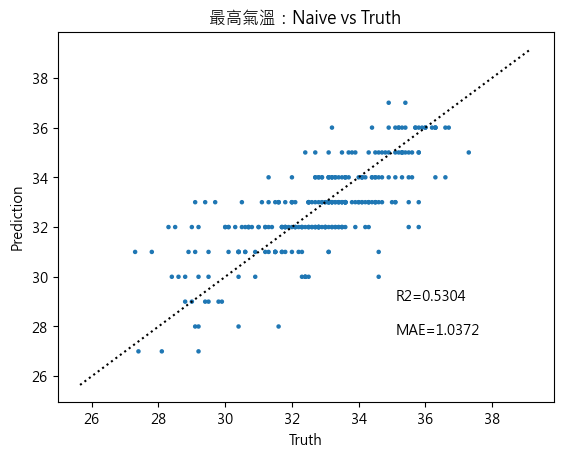

In [32]:
Y_feature = '最高氣溫'
X_features = ['溫度']
Xs, Ys, X_cols, town_and_date = get_XY_from_forecast_and_observation(forecast_df, observation_df, X_features, Y_feature)
Y_naive = np.max(Xs, axis=1)

fig, ax = plt.subplots()
naive_mae = plot_one_scatter(Ys, Y_naive, ax, '最高氣溫：Naive vs Truth')

### ML models

#### HyperParameter Tuning

In [28]:
Y_feature = '最高氣溫'
model_xcols = {
    'LinearRegression': ['溫度'],
    'FCN': ['溫度'],
    'RandomForest': ['溫度'],
    'XGBoost': ['溫度'],
    'SVR': ['溫度'],
    'NuSVR': ['溫度'],
    'LightGBM': ['溫度'],
}

if not optuna_done[Y_feature]:
    model_hyperparameters_dict = optuna_operation(model_xcols, Y_feature, forecast_df, observation_df)
else:
    model_hyperparameters_dict = {
        'LinearRegression': {},
        'FCN': {'L2_factor': 0.006367, 'dropout_factor':  0.1940},
        'RandomForest': {'max_depth': 4, 'n_estimators': 47},
        'XGBoost': {'max_depth': 2, 'n_estimators': 12},
        'LightGBM': {'max_depth': 4, 'n_estimators': 26},
        'SVR': {'C': 0.05584, 'kernel': 'linear'},
        'NuSVR': {'C': 0.09976, 'kernel': 'linear', 'nu': 0.7091},
    }

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.48it/s]


LinearRegression
Best R2 = 0.5536071014918189


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [25:14<00:00, 50.47s/it]


FCN
Best L2_factor = 0.021489297699436933
Best dropout_factor = 0.15637415818214406
Best R2 = 0.5761860813441155


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:16<00:00,  8.57s/it]


RandomForest
Best max_depth = 3
Best n_estimators = 63
Best R2 = 0.5419876456462301


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:37<00:00,  9.24s/it]


XGBoost
Best max_depth = 3
Best n_estimators = 10
Best R2 = 0.5239470733893565


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:58<00:00,  1.94s/it]


SVR
Best C = 0.025783540085003956
Best kernel = linear
Best R2 = 0.5498609195083419


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:39<00:00,  1.33s/it]


NuSVR
Best C = 0.29317090848841565
Best kernel = linear
Best nu = 0.43792723081125384
Best R2 = 0.5633448425194952


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:36<00:00,  7.21s/it]

LightGBM
Best max_depth = 9
Best n_estimators = 35
Best R2 = 0.5454575027502363
##### LinearRegression
Best R2 = 0.5536071014918189  
##### FCN
Best L2_factor = 0.021489297699436933  
Best dropout_factor = 0.15637415818214406  
Best R2 = 0.5761860813441155  
##### RandomForest
Best max_depth = 3  
Best n_estimators = 63  
Best R2 = 0.5419876456462301  
##### XGBoost
Best max_depth = 3  
Best n_estimators = 10  
Best R2 = 0.5239470733893565  
##### SVR
Best C = 0.025783540085003956  
Best kernel = linear  
Best R2 = 0.5498609195083419  
##### NuSVR
Best C = 0.29317090848841565  
Best kernel = linear  
Best nu = 0.43792723081125384  
Best R2 = 0.5633448425194952  
##### LightGBM
Best max_depth = 9  
Best n_estimators = 35  
Best R2 = 0.5454575027502363  


##### FCN
Best L2_factor = 0.006366896218364759  
Best dropout_factor = 0.19396856681257302  
Best R2 = 0.6048279316550031  
##### RandomForest
Best max_depth = 4  
Best n_estimators = 47  
Best R2 = 0.6352240070534566  
##### XGBoost
Best max_depth = 2  
Best n_estimators = 12  
Best R2 = 0.6272021513938951  
##### LightGBM
Best max_depth = 4  
Best n_estimators = 26  
Best R2 = 0.6061314180772585  
##### SVR
Best C = 0.05583870083012335  
Best kernel = linear  
Best R2 = 0.604340159328353  
##### NuSVR
Best C = 0.09975849736100006  
Best kernel = linear  
Best nu = 0.7091007437639489  
Best R2 = 0.6044918833713732

#### 集成學習

In [29]:
if weights_determined[Y_feature]:
    optimal_weights = {
        'RandomForest': 0.345,
        'XGBoost': 0.106,
        'LightGBM': 0.200,
        'SVR': 0.000,
        'NuSVR': 0.208,
        'FCN': 0.142,
    }
    print('Weights:')
    for i, k in enumerate(model_hyperparameters_dict.keys()):
        print(f'{k}: {optimal_weights[k]:.3f}')
else:
    if 'FCN' in model_hyperparameters_dict.keys():
        n_iters = 50
    else:
        n_iters = 200
    df, optimal_weights = find_avg_score_with_given_model_list(model_hyperparameters_dict, model_xcols, forecast_df, observation_df, Y_feature, n_iters=n_iters)
    display(df)
    print('Weights:')
    for i, k in enumerate(model_hyperparameters_dict.keys()):
        print(f'{k}: {optimal_weights[k]:.3f}')

this_model_path = train_model_path + f'{Y_feature}/'
os.makedirs(this_model_path, exist_ok=True)

save_model_metadata(Y_feature, this_model_path + 'meta.json', model_xcols, model_hyperparameters_dict, optimal_weights)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [08:43<00:00, 10.48s/it]


,Model,Avg MAE,Std MAE,90th percentile
0,Weighted_Ensemble,1.004056,0.101295,1.119538
1,Ensemble,1.011605,0.102609,1.128868
2,SVR,1.033696,0.102507,1.139215
3,NuSVR,1.032286,0.098137,1.145271
4,RandomForest,1.051253,0.110128,1.170525
5,XGBoost,1.061067,0.107402,1.174563
6,LinearRegression,1.050069,0.098484,1.177074
7,LightGBM,1.045305,0.110742,1.177332
8,FCN,1.050703,0.107676,1.182632


Weights:
LinearRegression: 0.000
FCN: 0.216
RandomForest: 0.000
XGBoost: 0.000
SVR: 0.019
NuSVR: 0.440
LightGBM: 0.325


## 低溫

### Navie

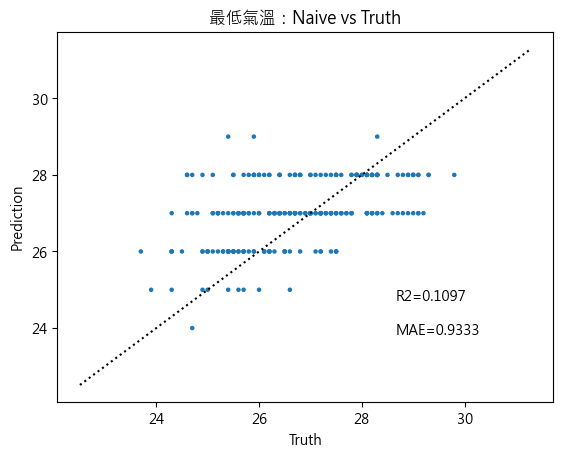

In [30]:
Y_feature = '最低氣溫'
X_features = ['溫度']
Xs, Ys, X_cols, town_and_date = get_XY_from_forecast_and_observation(forecast_df, observation_df, X_features, Y_feature)
Y_naive = np.min(Xs, axis=1)

fig, ax = plt.subplots()
naive_mae = plot_one_scatter(Ys, Y_naive, ax, '最低氣溫：Naive vs Truth')

### ML models

#### HyperParameters Tuning

In [31]:
Y_feature = '最低氣溫'
model_xcols = {
    'LinearRegression': ['溫度'],
    'FCN': ['溫度'],
    'RandomForest': ['溫度'],
    'XGBoost': ['溫度'],
    'SVR': ['溫度'],
    'NuSVR': ['溫度'],
    'LightGBM': ['溫度'],
}

if not optuna_done[Y_feature]:
    model_hyperparameters_dict = optuna_operation(model_xcols, Y_feature, forecast_df, observation_df)
else:
    model_hyperparameters_dict = {
        'LinearRegression': {},
        'FCN': {'L2_factor': 0.006579, 'dropout_factor':  0.2828},
        'RandomForest': {'max_depth': 5, 'n_estimators': 112},
        'XGBoost': {'max_depth': 2, 'n_estimators': 13},
        'LightGBM': {'max_depth': 6, 'n_estimators': 69},
        'SVR': {'C': 0.8540, 'kernel': 'rbf'},
        'NuSVR': {'C': 0.5960, 'kernel': 'rbf', 'nu': 0.6158}, 
    }

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.87it/s]


LinearRegression
Best R2 = 0.20054221190740057


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [22:32<00:00, 45.07s/it]


FCN
Best L2_factor = 0.03848118312551811
Best dropout_factor = 0.36426869854690025
Best R2 = 0.24343284524008463


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [06:00<00:00, 12.01s/it]


RandomForest
Best max_depth = 4
Best n_estimators = 120
Best R2 = 0.27829760748544896


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:59<00:00,  9.99s/it]


XGBoost
Best max_depth = 2
Best n_estimators = 98
Best R2 = 0.1822131477145608


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:35<00:00,  1.17s/it]


SVR
Best C = 0.2775491876288868
Best kernel = rbf
Best R2 = 0.23458016690574998


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:29<00:00,  1.01it/s]


NuSVR
Best C = 0.36897538170282823
Best kernel = rbf
Best nu = 0.6153407084238018
Best R2 = 0.22190513910258938


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.83s/it]

LightGBM
Best max_depth = 6
Best n_estimators = 21
Best R2 = 0.22883886740979453
##### LinearRegression
Best R2 = 0.20054221190740057  
##### FCN
Best L2_factor = 0.03848118312551811  
Best dropout_factor = 0.36426869854690025  
Best R2 = 0.24343284524008463  
##### RandomForest
Best max_depth = 4  
Best n_estimators = 120  
Best R2 = 0.27829760748544896  
##### XGBoost
Best max_depth = 2  
Best n_estimators = 98  
Best R2 = 0.1822131477145608  
##### SVR
Best C = 0.2775491876288868  
Best kernel = rbf  
Best R2 = 0.23458016690574998  
##### NuSVR
Best C = 0.36897538170282823  
Best kernel = rbf  
Best nu = 0.6153407084238018  
Best R2 = 0.22190513910258938  
##### LightGBM
Best max_depth = 6  
Best n_estimators = 21  
Best R2 = 0.22883886740979453  


##### FCN
Best L2_factor = 0.006578980595757985  
Best dropout_factor = 0.2827579002701865  
Best R2 = 0.12796332166141297  
##### RandomForest
Best max_depth = 5  
Best n_estimators = 112  
Best R2 = 0.23976560718955822  
##### XGBoost
Best max_depth = 2  
Best n_estimators = 13  
Best R2 = 0.26960230752782566  
##### LightGBM
Best max_depth = 6  
Best n_estimators = 69  
Best R2 = 0.14645030056603767  
##### SVR
Best C = 0.8539784496032792  
Best kernel = rbf  
Best R2 = 0.1879279073200762  
##### NuSVR
Best C = 0.5959731111440211  
Best kernel = rbf  
Best nu = 0.6158415473805077  
Best R2 = 0.18223342242299245  

#### 集成學習

In [32]:
if weights_determined[Y_feature]:
    optimal_weights = {
        'FCN': 0.013,
        'RandomForest': 0.237,
        'XGBoost': 0.726,
        'LightGBM': 0.000,
        'SVR': 0.024,
        'NuSVR': 0.000,
    }
    print('Weights:')
    for i, k in enumerate(model_hyperparameters_dict.keys()):
        print(f'{k}: {optimal_weights[k]:.3f}')
else:
    if 'FCN' in model_hyperparameters_dict.keys():
        n_iters = 50
    else:
        n_iters = 200
    df, optimal_weights = find_avg_score_with_given_model_list(model_hyperparameters_dict, model_xcols, forecast_df, observation_df, Y_feature, n_iters=n_iters)
    display(df)
    print('Weights:')
    for i, k in enumerate(model_hyperparameters_dict.keys()):
        print(f'{k}: {optimal_weights[k]:.3f}')

this_model_path = train_model_path + f'{Y_feature}/'
os.makedirs(this_model_path, exist_ok=True)

save_model_metadata(Y_feature, this_model_path + 'meta.json', model_xcols, model_hyperparameters_dict, optimal_weights)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:52<00:00, 11.84s/it]


,Model,Avg MAE,Std MAE,90th percentile
0,RandomForest,0.867530,0.071403,0.956766
1,Ensemble,0.871551,0.073479,0.968148
2,Weighted_Ensemble,0.864046,0.072704,0.968520
3,SVR,0.882290,0.077544,0.986242
4,NuSVR,0.889508,0.074193,0.990340
5,LightGBM,0.884150,0.079574,1.002169
6,LinearRegression,0.905936,0.071875,1.006265
7,FCN,0.915458,0.073913,1.012725
8,XGBoost,0.915383,0.080013,1.022323


Weights:
LinearRegression: 0.137
FCN: 0.000
RandomForest: 0.616
XGBoost: 0.095
SVR: 0.152
NuSVR: 0.000
LightGBM: 0.000


## 平均溫

### Naive

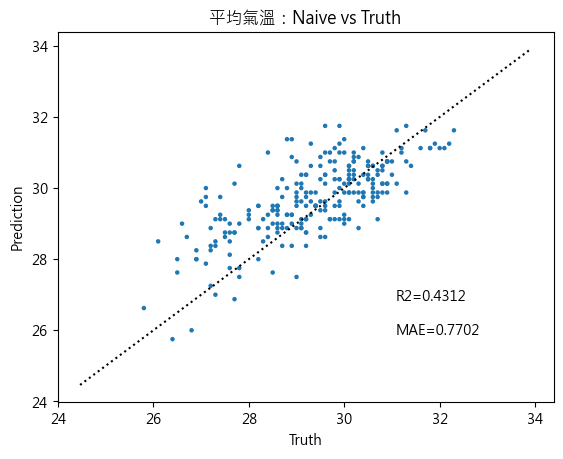

In [33]:
Y_feature = '氣溫'
X_features = ['溫度']
Xs, Ys, X_cols, town_and_date = get_XY_from_forecast_and_observation(forecast_df, observation_df, X_features, Y_feature)
Y_naive = np.mean(Xs, axis=1)

fig, ax = plt.subplots()
naive_mae = plot_one_scatter(Ys, Y_naive, ax, '平均氣溫：Naive vs Truth')

### ML models

#### HyperParameter Tuning

In [50]:
Y_feature = '氣溫'
model_xcols = {
    'LinearRegression': ['溫度'],
    'FCN': ['溫度'],
    'RandomForest': ['溫度'],
    'XGBoost': ['溫度'],
    'SVR': ['溫度'],
    'NuSVR': ['溫度'],
    'LightGBM': ['溫度'],
}

if not optuna_done[Y_feature]:
    model_hyperparameters_dict = optuna_operation(model_xcols, Y_feature, forecast_df, observation_df)
else:
    model_hyperparameters_dict = {
        'LinearRegression': {},
        'FCN': {'L2_factor': 0.02111, 'dropout_factor':  0.04274},
        'RandomForest': {'max_depth': 4, 'n_estimators': 195},
        'XGBoost': {'max_depth': 2, 'n_estimators': 13},
        'LightGBM': {'max_depth': 4, 'n_estimators': 59},
        'SVR': {'C': 0.4323, 'kernel': 'linear'},
        'NuSVR': {'C': 0.4439, 'kernel': 'linear', 'nu': 0.6158},   
    }

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.46it/s]


LinearRegression
Best R2 = 0.4742731780116096


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [23:36<00:00, 47.20s/it]


FCN
Best L2_factor = 0.007135102224516893
Best dropout_factor = 0.36526408104349045
Best R2 = 0.4981064943037922


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [05:57<00:00, 11.91s/it]


RandomForest
Best max_depth = 4
Best n_estimators = 104
Best R2 = 0.5173656585776879


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:48<00:00,  7.60s/it]


XGBoost
Best max_depth = 2
Best n_estimators = 27
Best R2 = 0.5109831826285968


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:56<00:00,  1.89s/it]


SVR
Best C = 0.007595904959168153
Best kernel = linear
Best R2 = 0.46426837972457596


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:05<00:00,  2.20s/it]


NuSVR
Best C = 0.5191274968321011
Best kernel = linear
Best nu = 0.31102374153630974
Best R2 = 0.47737770707053556


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:28<00:00,  4.95s/it]

LightGBM
Best max_depth = 3
Best n_estimators = 28
Best R2 = 0.4780599837245806
##### LinearRegression
Best R2 = 0.4742731780116096  
##### FCN
Best L2_factor = 0.007135102224516893  
Best dropout_factor = 0.36526408104349045  
Best R2 = 0.4981064943037922  
##### RandomForest
Best max_depth = 4  
Best n_estimators = 104  
Best R2 = 0.5173656585776879  
##### XGBoost
Best max_depth = 2  
Best n_estimators = 27  
Best R2 = 0.5109831826285968  
##### SVR
Best C = 0.007595904959168153  
Best kernel = linear  
Best R2 = 0.46426837972457596  
##### NuSVR
Best C = 0.5191274968321011  
Best kernel = linear  
Best nu = 0.31102374153630974  
Best R2 = 0.47737770707053556  
##### LightGBM
Best max_depth = 3  
Best n_estimators = 28  
Best R2 = 0.4780599837245806  


##### FCN
Best L2_factor = 0.021113413887458573  
Best dropout_factor = 0.04274367293005721  
Best R2 = 0.4378907066278211  
##### RandomForest
Best max_depth = 4  
Best n_estimators = 195  
Best R2 = 0.4844221100077036  
##### XGBoost
Best max_depth = 2  
Best n_estimators = 13  
Best R2 = 0.49093789697123874  
##### LightGBM
Best max_depth = 4  
Best n_estimators = 59  
Best R2 = 0.41187761974593445  
##### SVR
Best C = 0.018011043607669287  
Best kernel = linear  
Best R2 = 0.43636030323831526  
##### NuSVR
Best C = 0.43233258907999045  
Best kernel = linear  
Best nu = 0.39503695680211226  
Best R2 = 0.44385816055128674 

#### 集成學習

In [51]:
if weights_determined[Y_feature]:
    optimal_weights = {
        'FCN': 0.108,
        'RandomForest': 0.414,
        'XGBoost': 0.211,
        'LightGBM': 0.000,
        'SVR': 0.000,
        'NuSVR': 0.267,
    }
    print('Weights:')
    for i, k in enumerate(model_hyperparameters_dict.keys()):
        print(f'{k}: {optimal_weights[k]:.3f}')
else:
    if 'FCN' in model_hyperparameters_dict.keys():
        n_iters = 50
    else:
        n_iters = 200
    df, optimal_weights = find_avg_score_with_given_model_list(model_hyperparameters_dict, model_xcols, forecast_df, observation_df, Y_feature, n_iters=n_iters)
    display(df)
    print('Weights:')
    for i, k in enumerate(model_hyperparameters_dict.keys()):
        print(f'{k}: {optimal_weights[k]:.3f}')

this_model_path = train_model_path + f'{Y_feature}/'
os.makedirs(this_model_path, exist_ok=True)

save_model_metadata(Y_feature, this_model_path + 'meta.json', model_xcols, model_hyperparameters_dict, optimal_weights)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [10:14<00:00, 12.30s/it]


,Model,Avg MAE,Std MAE,90th percentile
0,XGBoost,0.699706,0.062786,0.780441
1,RandomForest,0.690357,0.065413,0.781034
2,Weighted_Ensemble,0.697286,0.065580,0.783172
3,Ensemble,0.715135,0.070915,0.818651
4,LightGBM,0.730055,0.072074,0.823256
5,NuSVR,0.750743,0.079534,0.847823
6,FCN,0.749609,0.078159,0.858154
7,LinearRegression,0.765836,0.078265,0.859460
8,SVR,0.755708,0.079260,0.873972


Weights:
LinearRegression: 0.000
FCN: 0.000
RandomForest: 0.329
XGBoost: 0.380
SVR: 0.000
NuSVR: 0.292
LightGBM: 0.000


# 風速

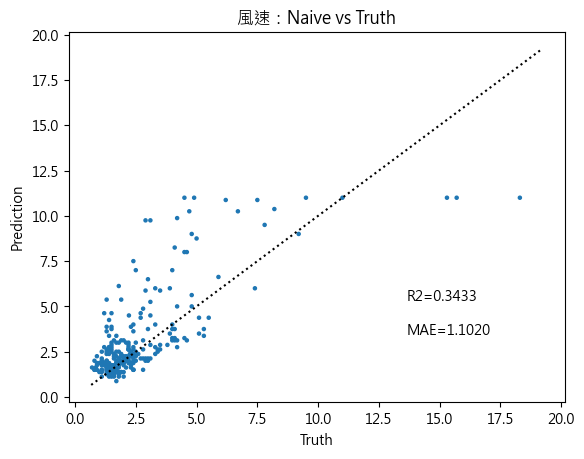

In [52]:
Y_feature = '風速'
X_features = ['風速']
Xs, Ys, X_cols, town_and_date = get_XY_from_forecast_and_observation(forecast_df, observation_df, X_features, Y_feature)
Y_naive = np.mean(Xs, axis=1)

fig, ax = plt.subplots()
naive_mae = plot_one_scatter(Ys, Y_naive, ax, '風速：Naive vs Truth')

In [53]:
Y_feature = '風速'
model_xcols = {
    'FCN': ['風速', '東西風', '南北風', '溫度'],
    'RandomForest': ['風速', '東西風', '南北風', '晴', '多雲', '陰', '短暫陣雨', '短暫陣雨或雷雨', '午後短暫雷陣雨', '陣雨或雷雨', '相對溼度', '溫度'],
    'XGBoost': ['風速', '東西風', '南北風', '溫度'],
    'LightGBM': ['風速', '東西風', '南北風', '溫度'],
    'SVR': ['風速', '東西風', '南北風', '溫度'],
    'NuSVR': ['風速', '東西風', '南北風', '溫度'],
}

if not optuna_done[Y_feature]:
    model_hyperparameters_dict = optuna_operation(model_xcols, Y_feature, forecast_df, observation_df)
else:
    model_hyperparameters_dict = {
        'FCN': {'L2_factor': 0.02111, 'dropout_factor':  0.04274},
        'RandomForest': {'max_depth': 8, 'n_estimators': 200},
        'XGBoost': {'max_depth': 2, 'n_estimators': 12},
        'LightGBM': {'max_depth': 3, 'n_estimators': 11},
        'SVR': {'C':  0.4405, 'kernel': 'linear'},
        'NuSVR': {'C': 0.01741, 'kernel': 'linear', 'nu': 0.6238}  
    }

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [23:53<00:00, 47.77s/it]


FCN
Best L2_factor = 0.0380233283613054
Best dropout_factor = 0.2717194384640461
Best R2 = 0.5742511349929164


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [15:54<00:00, 31.81s/it]


RandomForest
Best max_depth = 9
Best n_estimators = 81
Best R2 = 0.5088342150945102


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:34<00:00,  9.15s/it]


XGBoost
Best max_depth = 4
Best n_estimators = 72
Best R2 = 0.3360657007609732


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:50<00:00,  5.69s/it]


LightGBM
Best max_depth = 9
Best n_estimators = 12
Best R2 = 0.47523502876834395


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [05:10<00:00, 10.35s/it]


SVR
Best C = 0.17092333664978396
Best kernel = linear
Best R2 = 0.5503189490038392


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:04<00:00,  6.16s/it]

NuSVR
Best C = 0.14967725889383943
Best kernel = linear
Best nu = 0.44977298928259457
Best R2 = 0.5445423584551233
##### FCN
Best L2_factor = 0.0380233283613054  
Best dropout_factor = 0.2717194384640461  
Best R2 = 0.5742511349929164  
##### RandomForest
Best max_depth = 9  
Best n_estimators = 81  
Best R2 = 0.5088342150945102  
##### XGBoost
Best max_depth = 4  
Best n_estimators = 72  
Best R2 = 0.3360657007609732  
##### LightGBM
Best max_depth = 9  
Best n_estimators = 12  
Best R2 = 0.47523502876834395  
##### SVR
Best C = 0.17092333664978396  
Best kernel = linear  
Best R2 = 0.5503189490038392  
##### NuSVR
Best C = 0.14967725889383943  
Best kernel = linear  
Best nu = 0.44977298928259457  
Best R2 = 0.5445423584551233  


##### RandomForest
Best max_depth = 8  
Best n_estimators = 200  
Best R2 = 0.44476053459418435 
##### XGBoost
Best max_depth = 2  
Best n_estimators = 12  
Best R2 = 0.3950520622531771  
##### LightGBM
Best max_depth = 3  
Best n_estimators = 11  
Best R2 = 0.3505410125996822  
##### SVR
Best C = 0.4404862253598064  
Best kernel = linear  
Best R2 = 0.48936860838016016  
##### NuSVR
Best C = 0.017405206673103454  
Best kernel = linear  
Best nu = 0.623766887251527  
Best R2 = 0.45169718650072266

In [54]:
if weights_determined[Y_feature]:
    optimal_weights = {
        'RandomForest': 0.683,
        'XGBoost': 0.000,
        'LightGBM': 0.000,
        'SVR': 0.317,
        'NuSVR': 0.000,
    }
    print('Weights:')
    for i, k in enumerate(model_hyperparameters_dict.keys()):
        print(f'{k}: {optimal_weights[k]:.3f}')
else:
    if 'FCN' in model_hyperparameters_dict.keys():
        n_iters = 50
    else:
        n_iters = 200
    df, optimal_weights = find_avg_score_with_given_model_list(model_hyperparameters_dict, model_xcols, forecast_df, observation_df, Y_feature, n_iters=n_iters)
    display(df)
    print('Weights:')
    for i, k in enumerate(model_hyperparameters_dict.keys()):
        print(f'{k}: {optimal_weights[k]:.3f}')

this_model_path = train_model_path + f'{Y_feature}/'
os.makedirs(this_model_path, exist_ok=True)

save_model_metadata(Y_feature, this_model_path + 'meta.json', model_xcols, model_hyperparameters_dict, optimal_weights)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:20<00:00, 11.21s/it]


,Model,Avg MAE,Std MAE,90th percentile
0,RandomForest,0.768960,0.181824,0.955243
1,Weighted_Ensemble,0.733151,0.177583,0.965458
2,Ensemble,0.761450,0.179088,1.009334
3,SVR,0.785825,0.179480,1.016290
4,NuSVR,0.793766,0.182762,1.067177
5,FCN,0.901665,0.171696,1.112208
6,XGBoost,0.847077,0.207313,1.115917
7,LightGBM,0.893177,0.185794,1.171516


Weights:
FCN: 0.000
RandomForest: 0.583
XGBoost: 0.000
LightGBM: 0.000
SVR: 0.417
NuSVR: 0.000
